In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
x=pd.read_csv("nyc-rolling-sales.csv")
x.drop(x[x['YEAR BUILT']<1800].index, inplace=True)
x['EASE-MENT'].unique()
x.drop(columns=['EASE-MENT'], inplace=True)
x.drop_duplicates(inplace=True)

x.drop(columns=["Unnamed: 0"],inplace=True)
x['SALE DATE']=pd.to_datetime(x['SALE DATE']) + pd.offsets.MonthBegin(-1)


x=x.rename(columns={"SALE PRICE":"sales"})

x['sales']=pd.to_numeric(x.sales.astype(str).str.replace(',',''), errors='coerce')
x['GROSS SQUARE FEET']=pd.to_numeric(x['GROSS SQUARE FEET'].astype(str).str.replace(',',''), errors='coerce')
x['LAND SQUARE FEET']=pd.to_numeric(x['LAND SQUARE FEET'].astype(str).str.replace(',',''), errors='coerce')
x['sales']=x.sales.fillna(np.mean(x.sales))
population=x.groupby('NEIGHBORHOOD').count()[['LOT']].reset_index()
population['size']= np.where(population['LOT']<120, 'lower',(np.where((population['LOT']>=120) & (population['LOT']<240), 'middle','crowded')))
population['size'].value_counts()
population[['lower','middle','crowded']]=pd.get_dummies(population['size'])
population.drop(columns='size', inplace=True)
population.drop(columns='LOT', inplace=True)
x=x.merge(population, on='NEIGHBORHOOD', how='left')
x.drop(columns='NEIGHBORHOOD', inplace=True)
x=x[x['GROSS SQUARE FEET']>0]
x=x[x['LAND SQUARE FEET']>0]
x=x[x['sales']>1000]
x=x[x['sales']>x['sales'].quantile(0.15)]
x=x[x['sales']<x['sales'].quantile(0.85)]

x=x[x['LAND SQUARE FEET']>x['LAND SQUARE FEET'].quantile(0.05)]
x=x[x['LAND SQUARE FEET']<x['LAND SQUARE FEET'].quantile(0.95)]

x=x[x['GROSS SQUARE FEET']>x['GROSS SQUARE FEET'].quantile(0.05)]
x=x[x['GROSS SQUARE FEET']<x['GROSS SQUARE FEET'].quantile(0.95)]

x.dropna(inplace=True)

x['YEAR BUILT'] = np.where(x['YEAR BUILT'] > 1993, '30-',
                                           np.where((x['YEAR BUILT'] <= 1993) & (x['YEAR BUILT'] > 1963), '30-60',
                                                    np.where((x['YEAR BUILT'] <= 1963) & (x['YEAR BUILT'] > 1933), '60-90', '90+')))

x[pd.get_dummies(x['YEAR BUILT']).columns]=pd.get_dummies(x['YEAR BUILT'])


x.drop(columns='YEAR BUILT', inplace=True)

x[pd.get_dummies(x['TAX CLASS AT PRESENT']).columns]=pd.get_dummies(x['TAX CLASS AT PRESENT'])
x.drop(columns='ADDRESS', inplace=True)
x.drop(columns='TAX CLASS AT PRESENT', inplace=True)
x.drop(columns='APARTMENT NUMBER', inplace=True)
x.drop(columns=x.columns[x.dtypes=='object'], inplace=True)
x.drop(columns='BOROUGH', inplace=True)
x.drop(columns=['BLOCK','LOT','ZIP CODE'], inplace=True)
x.drop(columns=['RESIDENTIAL UNITS','COMMERCIAL UNITS','TOTAL UNITS'], inplace=True)
x=x.set_index("SALE DATE")

In [3]:
x

,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,sales,lower,middle,crowded,30-,30-60,60-90,90+,1,2,2A,2B,4
SALE DATE,,,,,,,,,,,,,,,,
2017-04-01,1779.0,3713.0,2,1.263354e+06,0,0,1,0,0,0,1,0,0,1,0,0
2017-03-01,2000.0,2520.0,1,1.263354e+06,1,0,0,0,0,0,1,1,0,0,0,0
2017-01-01,2227.0,3696.0,1,1.263354e+06,1,0,0,0,0,0,1,1,0,0,0,0
2017-08-01,3456.0,3636.0,4,1.263354e+06,1,0,0,1,0,0,0,0,0,0,0,1
2016-11-01,1675.0,3909.0,4,1.263354e+06,1,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-01,3325.0,1300.0,1,5.090000e+05,0,0,1,1,0,0,0,1,0,0,0,0
2016-11-01,3020.0,1800.0,1,1.263354e+06,0,0,1,1,0,0,0,1,0,0,0,0
2016-11-01,2400.0,2575.0,1,4.500000e+05,0,0,1,1,0,0,0,1,0,0,0,0


In [12]:
data=x.reset_index().corr()

C:\Users\ozan-\AppData\Local\Temp\ipykernel_11948\4253071135.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data=x.reset_index().corr()


<AxesSubplot: >

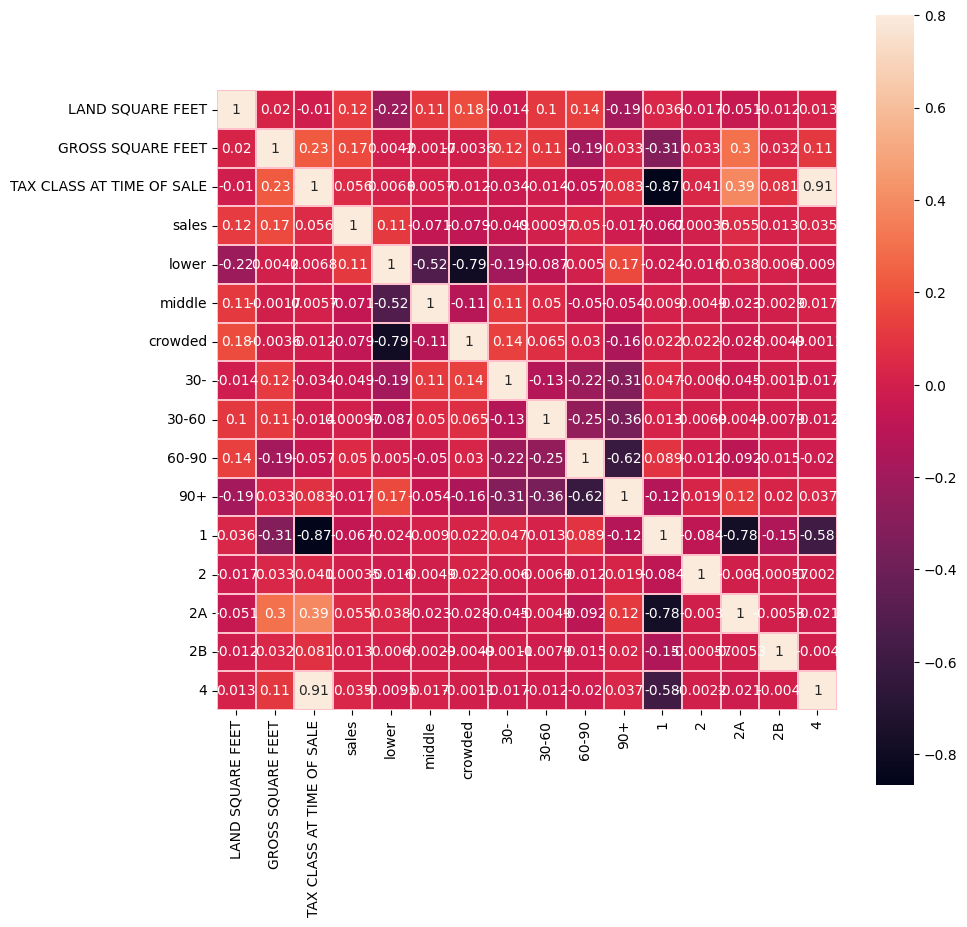

In [13]:
# Correlation Map
corr=data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(data, vmax=.8, linewidths=0.05,square=True,annot=True,linecolor="pink")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x.drop(columns='sales'), x.sales, test_size=0.10,random_state=42)

In [15]:
model= RandomForestRegressor()
model.fit(X_train, y_train)
pred=model.predict(X_test)

In [16]:
r2_score(y_test, pred)

-0.0518480311749685

In [17]:
for i,j in zip(X_train.columns, model.feature_importances_):
    print(i,j)

r2_score(y_test, pred)

LAND SQUARE FEET 0.3810242097928673
GROSS SQUARE FEET 0.4933733714132952
TAX CLASS AT TIME OF SALE 0.0051429590380020545
lower 0.026860807392570015
middle 0.007233379550955752
crowded 0.008984363522452946
30- 0.012177084784440923
30-60 0.01490254244986354
60-90 0.0196941565819144
90+ 0.021297629234476183
1 0.0035219794458737955
2 5.4747899937182354e-05
2A 0.0030112772650741785
2B 0.00023450163143610018
4 0.0024869899968401788


-0.0518480311749685

In [18]:
model= LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [19]:
pred=model.predict(X_test)
r2=r2_score(y_test,pred)
r2

0.04900678939919212